## Reload the `EC_estimator.py` code to consider any changes

In [28]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import EC_estimator as annec

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [6]:
tf.__version__

'2.2.0'

## Load the dataset, preprocessing, and apply ANN model

In [ ]:
# Load data
df = annec.load_data('Inputs/inputs.csv')
# Set date as index and parse as datetime
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df_var = annec.df_by_variable(df)

# Split data by year: 1923-1939 for test, 1940-2015 for training
df_test = df_var[(df_var.index.year >= 1923) & (df_var.index.year <= 1939)]
df_train_full = df_var[(df_var.index.year >= 1940) & (df_var.index.year <= 2015)]

# Further split training data: 80% for training, 20% for validation
# Using random masks approach similar to annutilsr
calib_prop = 0.8  # 80% of the data for calibration
vset = np.random.rand(df_train_full.shape[0])
train_mask = vset < calib_prop
val_mask = (vset >= calib_prop) & (vset < (calib_prop + 0.2))

df_train = df_train_full[train_mask]
df_val = df_train_full[val_mask]

# Build model inputs
inputs = annec.build_model_inputs(df_var)

# Preprocessing layers
layers = annec.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annec.build_model(layers, inputs)


X_train = [ df_train.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]

y_train = df_train[('EC','0d')].to_frame()  # situation where one column is produced and coerced to a series
# Otherwise you would do something like:
#y.droplevel(level='lag',axis=1).rename(mapper={"EC":"emm_ec"})
y_train.columns = ["emm_ec"]


X_val = [ df_val.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]

y_val = df_val[('EC','0d')].to_frame()
y_val.columns = ["emm_ec"]


X_test = [ df_test.loc[:, pd.IndexSlice[feature,annec.lags_feature[feature]]] for feature in annec.feature_names()]


y_test = df_test[('EC','0d')].to_frame()  # Only works for univariate dataset where it is a series
y_test.columns = ["emm_ec"] 


# Train model with validation data
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_val, y_val)

## Illustration of by-variable input (df_var)

In [20]:
df = annec.load_data('Inputs/inputs.csv')

# This will break up the incoming DataFrame into a MultiIndex column
# with the site/variable (e.g. Sac) as the 0-level index and
# lag (e.g. '3d') as the fast index.
df_var = annec.df_by_variable(df)

# This is an illustration of how to extract a single location/variable
# so that it (with its lags) can be used as a single input in the ANN. 
# In the traditional CalSIM model would be 18 values 
# The droplevel gets rid of the vestiges of the multiindex
sac = df_var.loc[:, pd.IndexSlice['sac',:]].droplevel(level="var",axis=1)
print(sac.head(4))





lag           0d           1d           2d           3d           4d  \
0    22290.01548  22333.70068  22358.59029  22373.94862  22383.92889   
1    22203.28407  22290.01548  22333.70068  22358.59029  22373.94862   
2    21992.03107  22203.28407  22290.01548  22333.70068  22358.59029   
3    18938.58199  21992.03107  22203.28407  22290.01548  22333.70068   

lag           5d           6d           7d         1ave         2ave  \
0    22390.61113  22395.12267  22398.10862  22391.45013  20455.31666   
1    22383.92889  22390.61113  22395.12267  22394.40549  21187.05572   
2    22373.94862  22383.92889  22390.61113  22396.15244  21864.78865   
3    22358.59029  22373.94862  22383.92889  22396.79180  22157.44139   

lag         3ave         4ave         5ave         6ave         7ave  \
0    13808.89333  13727.31347  15871.35388  18889.58980  19086.62041   
1    13863.05279  13723.46477  15415.59194  18875.79859  19027.33307   
2    13971.76887  13721.41293  14965.45140  18855.52854  18992

## Evaluation of the model

In [21]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("predictions")
print(y_train_pred[-4:-1])
print(y_test_pred[-4:-1])
print("input data")
print(X_train[0].iloc[-4:-1])
print(X_test[0].iloc[-4:-1])
print("end predictions")
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)

#print(tabulate(df3, headers='keys', tablefmt='psql'))



predictions
[[331.60553]
 [200.18011]
 [200.46124]]
[[1296.0256]
 [1233.2865]
 [1090.4393]]
input data
var                  sac                                            \
lag                   0d            1d            2d            3d   
date                                                                 
1954-10-04   13908.54682   14129.58549   14660.19664   16532.08264   
1942-05-10   40440.26801   40451.87218   40467.36742   40489.07689   
1983-03-31  224088.75280  226851.12120  228001.80680  228587.56680   

var                                                                 \
lag                   4d            5d            6d            7d   
date                                                                 
1954-10-04   18162.08380   18668.36665   18876.46615   18981.59644   
1942-05-10   40521.19806   40572.00368   40659.75914   40831.74605   
1983-03-31  228925.01890  229136.39370  229276.96020  229374.65900   

var                                                    

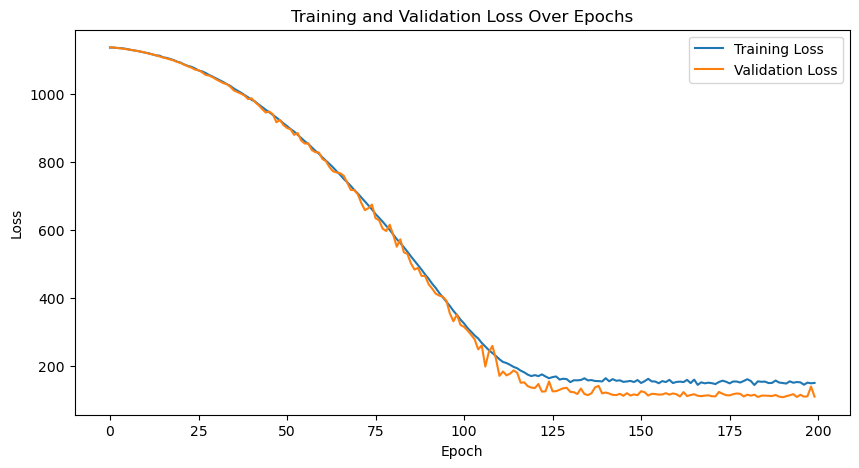

In [22]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    946.589111
Name: 1939-12-31 00:00:00, dtype: float32


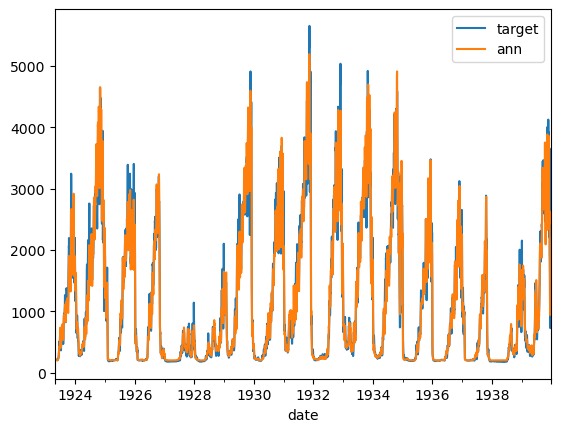

In [23]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [24]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [25]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |      0.986 |       103.92 |                    3.39 |     0.973 |      178.66 |                   1.68 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [26]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

model_save_path = r'./Export/emmaton'
loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
print("Model Signature:")
loaded_model.summary()

Model Signature:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sac_input (InputLayer)          [(None, 18)]         0                                            
__________________________________________________________________________________________________
exports_input (InputLayer)      [(None, 18)]         0                                            
__________________________________________________________________________________________________
dcc_input (InputLayer)          [(None, 18)]         0                                            
__________________________________________________________________________________________________
net_dcd_input (InputLayer)      [(None, 18)]         0                                            
___________________________________________________________________________

In [27]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("./Inputs/selected.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)





Sample
[array([[ 7717.142,  7716.127,  7715.153,  7714.168,  7713.113,  7711.911,
         7710.454,  7708.58 ,  7413.865,  6964.834,  6990.893,  9085.646,
        10543.928, 10538.482,  9573.437,  9400.652, 10259.991, 19202.16 ]]), array([[ 3505.366,  3505.366,  3505.366,  3505.366,  3505.366,  3505.366,
         3505.366,  3505.366,  3228.763,  2744.708,  2744.708,  4691.516,
         6313.855,  6313.855,  4611.389,  4233.064,  4233.064, 11767.55 ]]), array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   , 16.364, 30.   , 30.   , 30.818, 31.   ,
        31.   , 31.   ]]), array([[1632.914, 1632.914, 1632.914, 1632.914, 1632.914, 1632.914,
        1632.914, 1632.914, 1364.777,  895.536,  895.536, 1093.966,
        1259.325, 1259.325, 2029.012, 2200.054, 2200.054, 2565.653]]), array([[1277.638, 1277.781, 1277.942, 1278.132, 1278.363, 1278.656,
        1279.04 , 1279.564, 1347.192, 1445.815, 1443.771, 1205.677,
        1039.761, 1039.77 , 